In [7]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from swdf.plots import *

os              : Linux-6.8.0-41-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# Predictions with Ap and Dst Indices Forecast Model

This notebook compiles various plots of predictions generated by the trained model to evaluate its performance. 

In [8]:
df = load_object("preprocessed_data/dataframes/geodstap.pkl")
model_data = torch.load("models/best/best_model_geodstap.pth")
data_columns = ['DST', 'AP']

lookback = model_data['lookback']
horizon = model_data['horizon']
models = model_data['models']
df

,Datetime,DST,AP
0,1957-01-01 00:00:00,12.000000,2
1,1957-01-01 03:00:00,9.300000,3
2,1957-01-01 06:00:00,5.000000,3
3,1957-01-01 09:00:00,-5.000000,22
4,1957-01-01 12:00:00,0.000000,15
...,...,...,...
197518,2024-08-06 18:00:00,-14.300000,5
197519,2024-08-06 21:00:00,-18.700001,6
197520,2024-08-07 00:00:00,-17.299999,4
197521,2024-08-07 03:00:00,-16.000000,6


In [9]:
lookback_data = df[data_columns].iloc[-(lookback+horizon):-horizon]

X_forecast = torch.tensor(lookback_data.values.T).float().unsqueeze(0).to(device)
X_forecast.shape

torch.Size([1, 2, 96])

In [10]:
with torch.no_grad():
    predictions = []
    for model in models:
        model.eval()
        predictions.append(model(X_forecast))
        predictions = torch.stack(predictions, dim=0)

        predictions = predictions.mean(dim=0)



preds_df = pd.DataFrame(predictions.squeeze(0).T, columns=data_columns)
true_df = df[df.Datetime > df.Datetime.max()-pd.DateOffset(hours=horizon*3)]

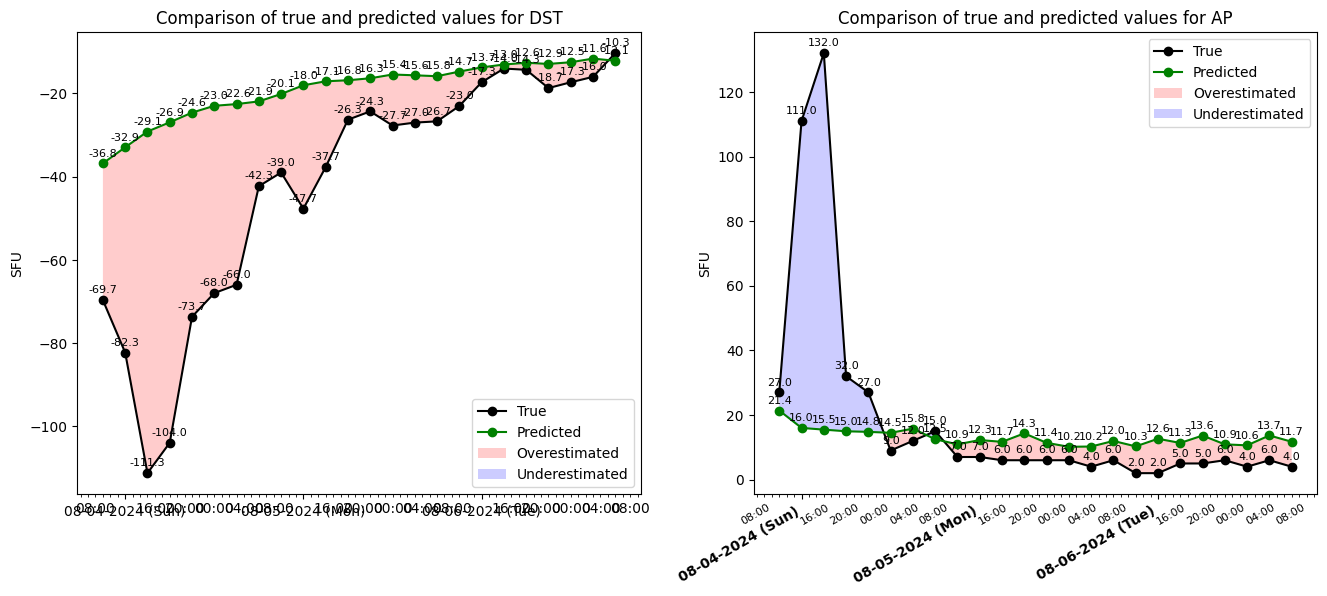

In [11]:
plot_predictions_performance(true_df, preds_df, data_columns=data_columns)

Timestamp('2024-08-07 06:00:00')

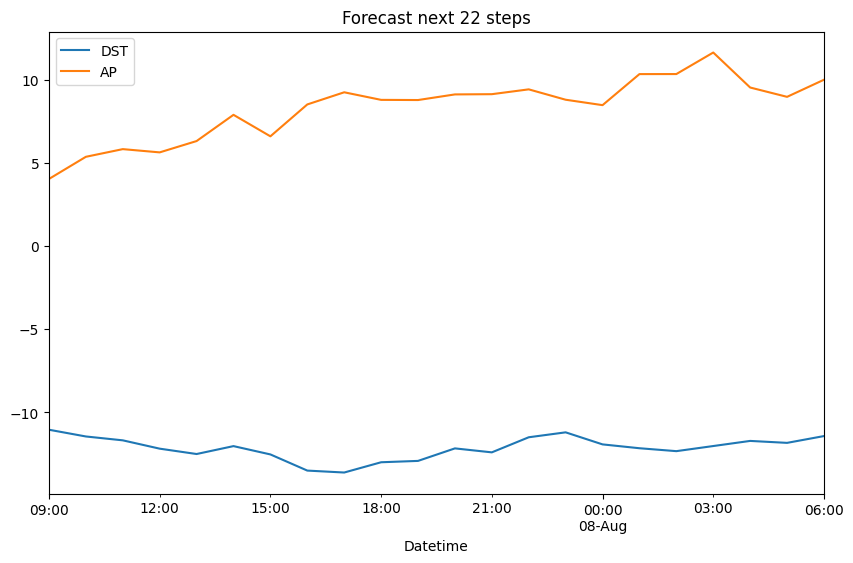

In [12]:
steps_to_forecast = 22
to_forecast_df = df.iloc[-lookback:]

def recurent_forecasting(df, days_to_forecast=12):
    to_forecast_df = df.copy()
    forecasted_days = 0

    while forecasted_days < days_to_forecast:
        lookback_data = to_forecast_df[data_columns].iloc[-lookback:]

        X_forecast = torch.tensor(lookback_data.values.T).float().unsqueeze(0).to(device)

        with torch.no_grad():
            predictions = model(X_forecast)

        dates = [to_forecast_df.Datetime.max() + dt.timedelta(hours=j) for j in range(1, horizon+1)]
        pred_df = pd.DataFrame(predictions.squeeze(0).T, columns=data_columns)
        pred_df['Datetime'] = dates
        to_forecast_df = pd.concat([to_forecast_df, pred_df], axis=0, ignore_index=True).reset_index(drop=True)
        
        forecasted_days += len(dates)
    
    return to_forecast_df

forecasts = recurent_forecasting(to_forecast_df, steps_to_forecast)
forecasts.iloc[-steps_to_forecast:].plot(x='Datetime', y=data_columns, figsize=(10, 6), title=f'Forecast next {steps_to_forecast} steps')
    


df.Datetime.max()

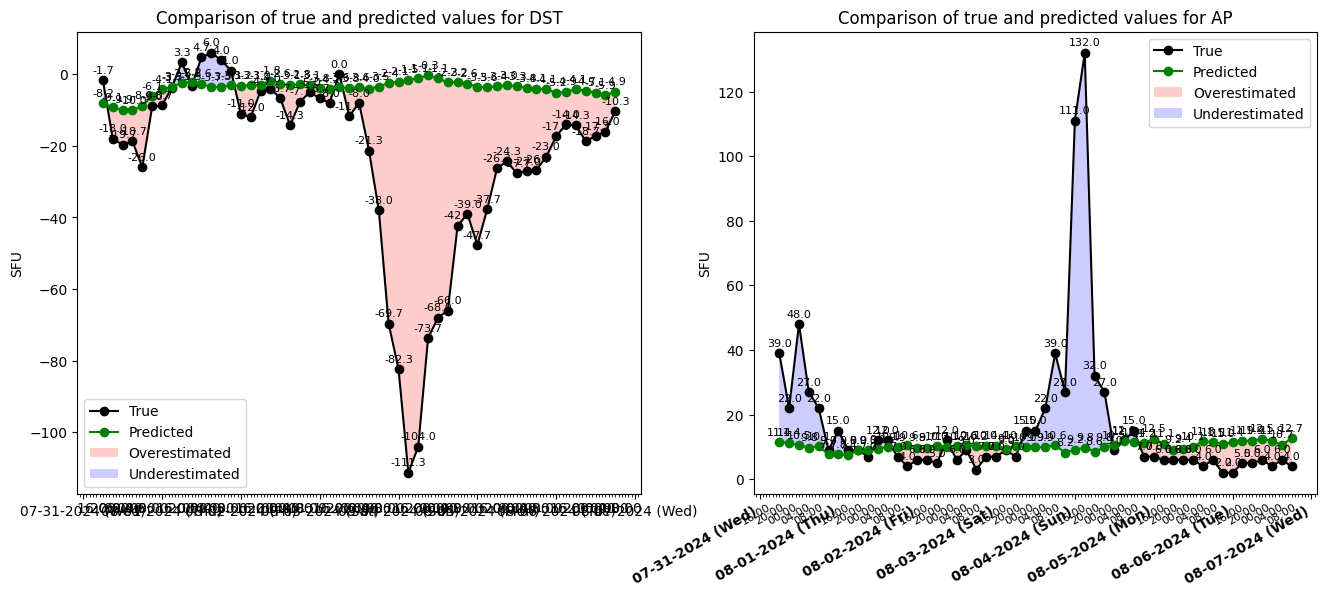

In [14]:
steps_to_forecast = 50

to_forecast_df = df.iloc[-(lookback+steps_to_forecast):-steps_to_forecast]

preds_df = recurent_forecasting(to_forecast_df, steps_to_forecast)[data_columns].iloc[-(steps_to_forecast+3):]
true_df = df[data_columns + ['Datetime']].iloc[-(steps_to_forecast + 3):]
plot_predictions_performance(true_df, preds_df, data_columns=data_columns)

In [15]:
start_date = pd.Timestamp('2023-03-10')
end_date = pd.Timestamp('2023-05-17')

X_tensor = prepare_tensor_to_forecast_histogram(
    df, 
    AttrDict(model_data), 
    start_date=start_date,
    end_date=end_date
)
model.eval()

with torch.no_grad():
    preds = model(X_tensor)

true_df = df[(df.Datetime >= start_date) & (df.Datetime <= end_date)] 
 
preds.shape

torch.Size([570, 2, 24])

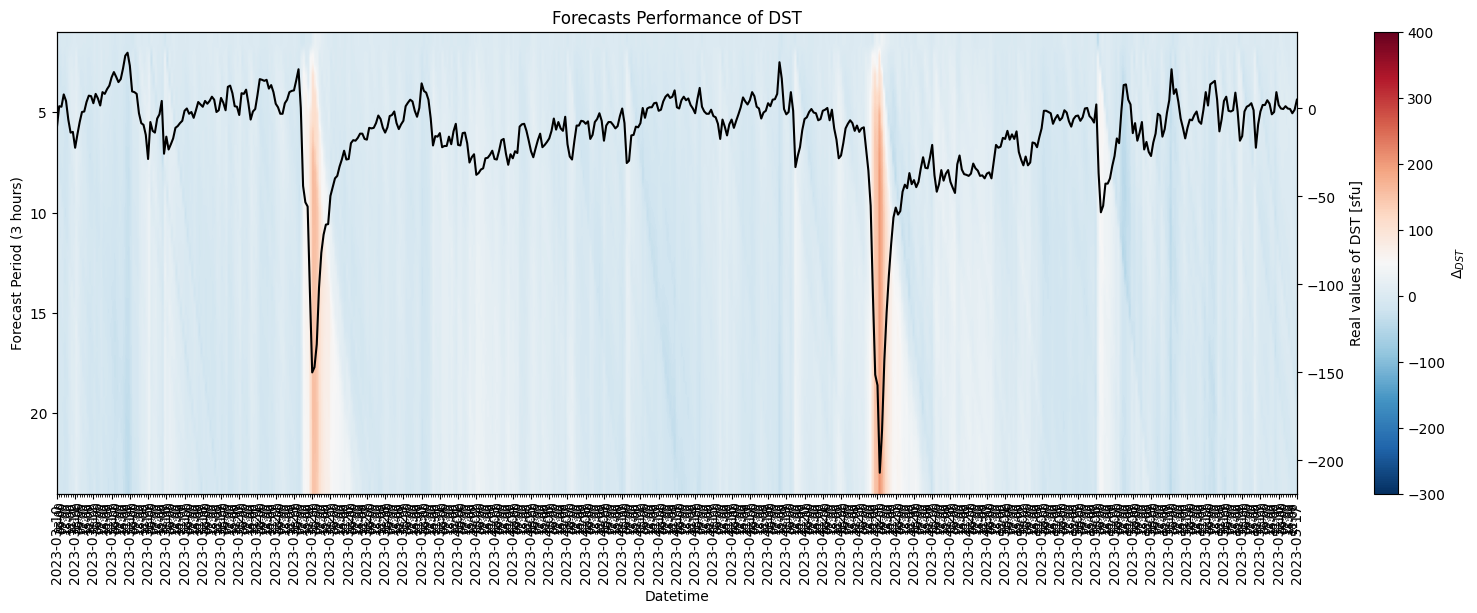

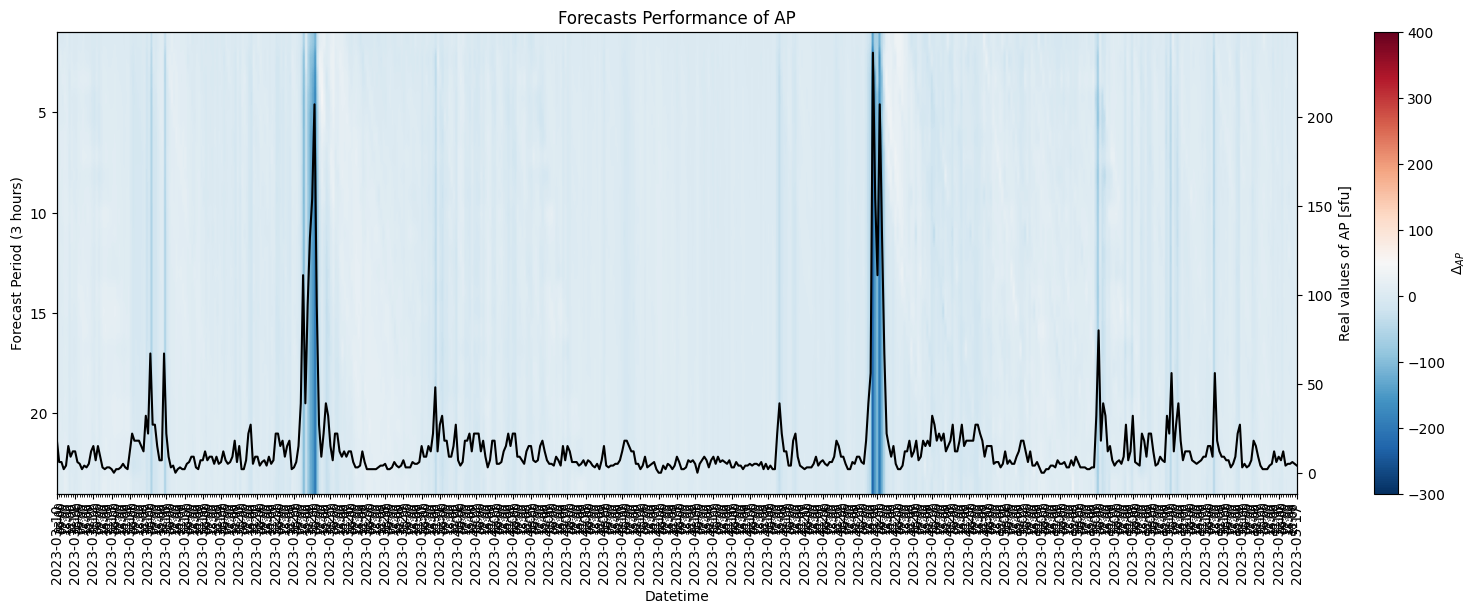

In [16]:

plot_histogram_with_accuracy_preds(
    true_df, 
    preds,
    data_columns=data_columns
)